In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

# from models import ResNet as resnet_cifar

from models import ResNet as resnet_cifar

import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader
from summaries import TensorboardSummary

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库
# import torch
# torch.cuda.set_device(0)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print('Initialization')
print('Init Finished!')

Initialization
Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 256
# PATH = '../tb_dir/cifar_exp/step_regularize_5_1'
args_depth = 20
num_classes = 10

PATH = './tb_exp/gumbel_mask/test_256bs_150epoch_layer3_senet'
model_path = os.path.join(PATH, 'saved_model.pt')

In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = resnet_cifar(depth=args_depth, num_classes=num_classes)
model = model.cuda()
model = torch.nn.DataParallel(model)
# model = torch.load(model_path)

model.load_state_dict(torch.load(model_path))
print('Successfully Load Model: ', os.path.basename(model_path))

Successfully Load Model:  saved_model.pt


In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [6]:
valueCount = [0]*10
# print(valueCount[0])
def countMaskValue(mask):
    global alueCount
    for i in range(10):
        if i == 0:
            temp = (mask>=0.1*i) & (mask<=0.1*i+0.1) 
        else:
            temp = (mask>0.1*i) & (mask<=0.1*i+0.1)
        valueCount[i] = valueCount[i] + torch.sum(temp.int())

In [14]:
def plotHistogram():
    global valueCount
    valueCount = np.array(valueCount)
    valueCount = valueCount / np.sum(valueCount)
    lim = np.arange(0,1,step=0.1)
    plt.bar(lim,valueCount,width=0.08)
    plt.title('SENet Mask')
    plt.ylabel('Percentage')
    plt.xlabel('Mask Value')
    plt.show()

In [8]:
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.to('cuda:0'))
        labels = Variable(labels.to('cuda:0'))
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs,mask = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    y = labels.data
    batch_size = labels.data.shape[0]
    
    countMaskValue(mask)
    
    running_corrects += torch.sum(preds == y)
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
epoch_acc = float(running_corrects) /dataset_sizes[phase]
print(dataset_sizes[phase])
print('%s top1 Acc:%.4f'%(phase,epoch_acc))


>>>>>>[7%]

/home/zengyuyuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[99%]10000
val top1 Acc:0.8675


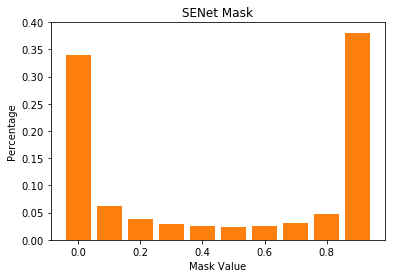

In [15]:
plotHistogram()